## Random search compression on LeNet-5

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.rnd import RandomController
from utils.train import *
from utils.weight_sharing import *
from utils.plot import *

Setting some global parameters 

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = './models/lenet/saves/lenet.save'

ACC_MULTIPLIER = 4
CR_MULTIPLIER = 1

NUM_INDIVIDUALS = 400

SAVE_RND_FILE = './results/test_RND_save.csv'
SAVE_EVERY = 1

RANGE_OPTIMIZATION = True

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
share_order = [0, 1, 2, 3, 4]
retrain_amount = [0, 0, 0, 0, 0]
prec_reduct = ['f4', 'f4', 'f4', 'f4', 'f4']

def fitness_fc(share):
    # reset the net
    get_trained(model, NET_PATH, train_settings)
    ws_controller.reset()
    
    # share weigts by particle

    share.data = ws_controller.share(share.representation, share_order, retrain_amount, prec_reduct)

    if share.data['accuracy'] <= 0.95:
        return share.data['accuracy']

    return 1 / math.sqrt(pow(1 - ((share.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (share.data['compression']/14), 2))

In [6]:
data = {
    'fitness': [],
    'representation': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

rnd_data = pd.read_csv(SAVE_RND_FILE).astype(data_types) if os.path.exists(SAVE_RND_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(rnd_controler:RandomController):
    global rnd_data

    new_data = copy.deepcopy(data)

    indiv = rnd_controler.current_indiv

    new_data['fitness'].append(indiv.fitness)
    new_data['representation'].append(indiv.representation)
    new_data['accuracy'].append(indiv.data['accuracy'])
    new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
    new_data['compression'].append(indiv.data['compression'])
    new_data['share_t'].append(indiv.data['times']['share'])
    new_data['train_t'].append(indiv.data['times']['train'])
    new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    rnd_data = rnd_data.append(pd.DataFrame(new_data).astype(data_types))
    rnd_data.reset_index(drop=True, inplace=True)
    os.makedirs(os.path.dirname(SAVE_RND_FILE), exist_ok=True)
    rnd_data.to_csv(SAVE_RND_FILE, index=False)

Setting ranges with optimization

In [7]:
repr_ranges = [range(1, 51), range(1, 51), range(1, 51), range(1, 51), range(1, 51)]

lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    repr_ranges = ws_controller.get_optimized_layer_ranges(repr_ranges, lam_test_inp, 0.97, savefile='./results/lenet-layer-perf.csv')

repr_ranges

[[2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30

Running the search

In [8]:
random = RandomController(repr_ranges, fitness_fc)

if rnd_data.size != 0:
    random.load_from_pd(rnd_data)

random.run(NUM_INDIVIDUALS, logger_fc, verbose = True)

Individual 1/400 (1) evaluated Individual ([21, 50, 30, 46, 32]) fit:1.4959946342593988
Individual 2/400 (2) evaluated Individual ([43, 37, 46, 24, 39]) fit:1.4414202168158468
Individual 3/400 (3) evaluated Individual ([9, 41, 36, 20, 41]) fit:1.5318336792060365
Individual 4/400 (4) evaluated Individual ([6, 42, 27, 18, 25]) fit:1.6839913640030215
Individual 5/400 (5) evaluated Individual ([23, 36, 50, 31, 31]) fit:1.4955204580550672
Individual 6/400 (6) evaluated Individual ([43, 14, 39, 5, 43]) fit:1.6113959372888051
Individual 7/400 (7) evaluated Individual ([28, 5, 38, 5, 45]) fit:1.6019354516955417
Individual 8/400 (8) evaluated Individual ([38, 7, 11, 3, 24]) fit:2.168209453905846
Individual 9/400 (9) evaluated Individual ([28, 38, 6, 33, 6]) fit:1.8062955812720833
Individual 10/400 (10) evaluated Individual ([15, 38, 15, 40, 50]) fit:1.5511637693040854
Individual 11/400 (11) evaluated Individual ([13, 44, 46, 41, 21]) fit:1.5193874664067855
Individual 12/400 (12) evaluated Indiv

[2, 44, 13, 16, 7]

See output

In [9]:
rnd_data

,fitness,representation,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,1.495995,"[21, 50, 30, 46, 32]",0.9850,-0.0004,4.880340,1.832584,0.0,3.822139
1,1.441420,"[43, 37, 46, 24, 39]",0.9858,-0.0012,4.492987,1.788167,0.0,4.093754
2,1.531834,"[9, 41, 36, 20, 41]",0.9840,0.0006,5.139382,1.434813,0.0,4.299481
3,1.683991,"[6, 42, 27, 18, 25]",0.9838,0.0008,6.001761,1.199480,0.0,4.009517
4,1.495520,"[23, 36, 50, 31, 31]",0.9846,0.0000,4.890368,1.839025,0.0,4.410616
...,...,...,...,...,...,...,...,...
395,1.725329,"[33, 32, 17, 24, 5]",0.9856,-0.0010,6.140028,0.954909,0.0,4.069628
396,1.477181,"[36, 41, 29, 18, 33]",0.9844,0.0002,4.777563,1.314678,0.0,4.119536
397,1.569794,"[44, 13, 9, 45, 37]",0.9840,0.0006,5.367524,0.918030,0.0,4.166557
398,1.561205,"[19, 15, 31, 47, 42]",0.9846,0.0000,5.295604,1.466247,0.0,3.914618


Plotting data

Text(0.5, 1.0, 'Random search on LeNet-5')

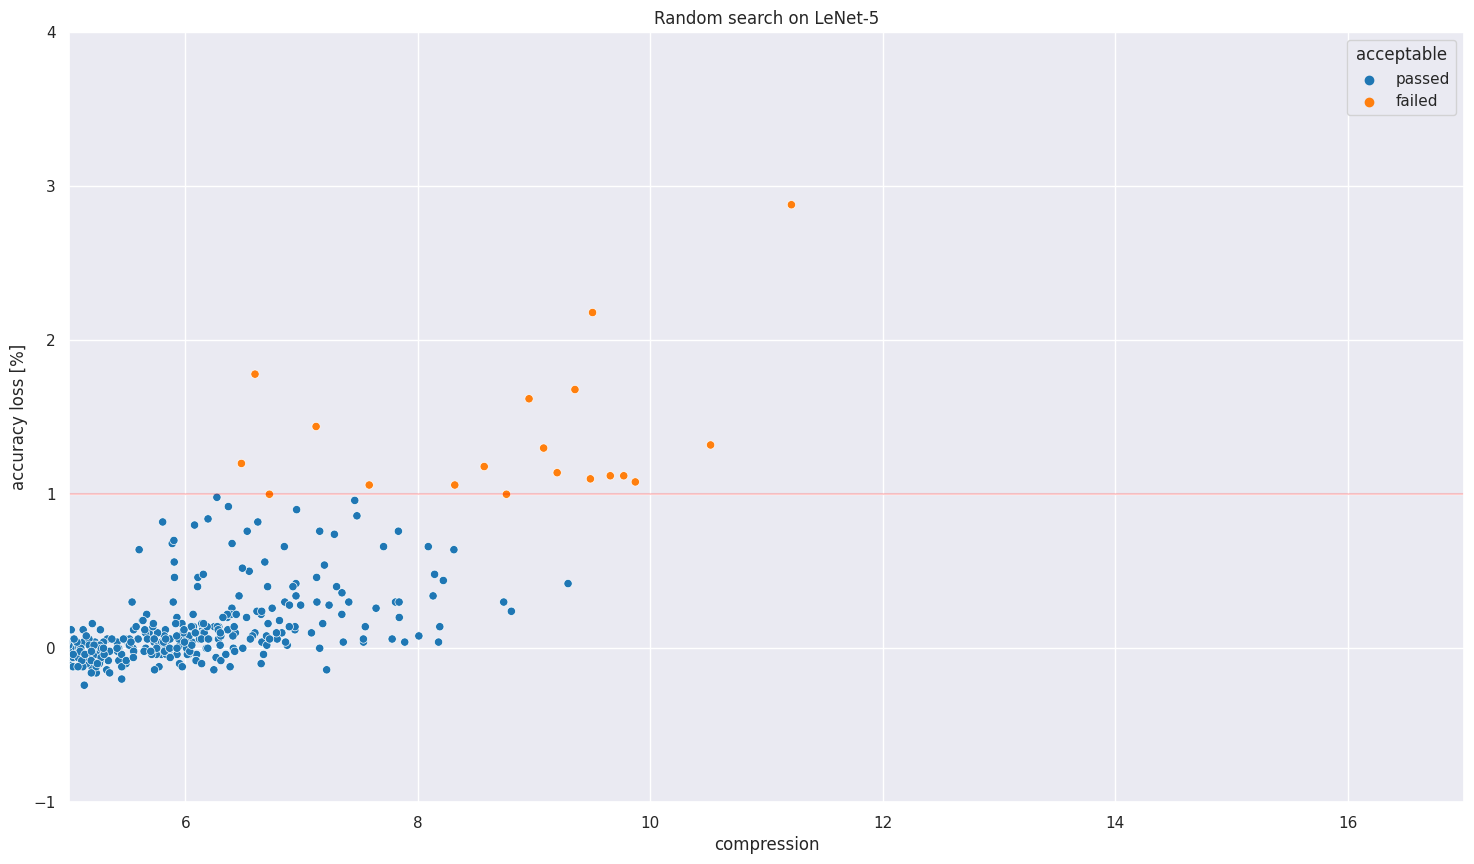

In [10]:
plot_alcr(rnd_data)
plt.title('Random search on LeNet-5')